In [4]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from types import SimpleNamespace

# Directory containing run results
RUNS_DIR = './results/runs'

def load_runs(run_dir=RUNS_DIR, filter_str=None):
    """
    Load all run results from the specified directory.
    Optionally filter by filename string.
    """
    if not os.path.exists(run_dir):
        print(f"Error: Directory {run_dir} not found.")
        return {}
        
    pkl_files = glob.glob(os.path.join(run_dir, "*.pkl"))
    
    if filter_str:
        pkl_files = [f for f in pkl_files if filter_str in os.path.basename(f)]
        
    runs = {}
    print(f"Found {len(pkl_files)} run files:")
    
    for filepath in pkl_files:
        try:
            with open(filepath, 'rb') as f:
                data = pickle.load(f)
                
            # Create a unique name for the plot legend
            # e.g., "SGD (lr=0.1)" or just filename if complex
            filename = os.path.basename(filepath).replace('.pkl', '')
            name = f"{filename}"
            
            # Wrap metrics in SimpleNamespace for compatibility with plotting functions
            # The plotting functions expect obj.train_losses, etc.
            metrics_obj = SimpleNamespace(**data['metrics'])
            
            # Attach hyperparameters for reference
            metrics_obj.hyperparameters = data.get('hyperparameters', {})
            metrics_obj.name = data['name']
            metrics_obj.timestamp = data.get('timestamp', '')
            
            runs[name] = metrics_obj
            print(f"  - Loaded: {filename}")
            
        except Exception as e:
            print(f"  - Error loading {filepath}: {e}")
            
    return runs

# Load all runs
# You can pass a string to filter, e.g., load_runs(filter_str="sgd")
metrics_dict = load_runs()

if not metrics_dict:
    print("\nNo runs loaded. Please run experiments in 'nn_run_experiments.ipynb' first.")


Found 3 run files:
  - Loaded: sgda_lr0.5_sigma0.1_kappa0.75
  - Loaded: sgd_fixed_lr=0.01
  - Loaded: sgd_multistep_lr=0.1


## Visualization Functions

In [5]:
COLORS = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'cyan', 'magenta', 'olive', 'pink']

def plot_comparison(metrics_dict, title="Algorithm Comparison"):
    """
    Plot comparison of multiple algorithms.
    
    Args:
        metrics_dict: Dictionary of {name: MetricsObject}
    """
    figsize = (10, 6)
    dpi = 300
    
    # Plot 1: Training Loss Comparison
    plt.figure(figsize=figsize, dpi=dpi)
    for i, (name, metrics) in enumerate(metrics_dict.items()):
        epochs = range(1, len(metrics.train_losses) + 1)
        plt.plot(epochs, metrics.train_losses, color=COLORS[i], label=name, linewidth=1.5)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title(f'{title} - Training Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Test Loss Comparison
    plt.figure(figsize=figsize, dpi=dpi)
    for i, (name, metrics) in enumerate(metrics_dict.items()):
        epochs = range(1, len(metrics.test_losses) + 1)
        plt.plot(epochs, metrics.test_losses, color=COLORS[i], label=name, linewidth=1.5)
    plt.xlabel('Epoch')
    plt.ylabel('Test Loss')
    plt.title(f'{title} - Test Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Training Accuracy Comparison
    plt.figure(figsize=figsize, dpi=dpi)
    for i, (name, metrics) in enumerate(metrics_dict.items()):
        epochs = range(1, len(metrics.train_accs) + 1)
        plt.plot(epochs, metrics.train_accs, color=COLORS[i], label=name, linewidth=1.5)
    plt.xlabel('Epoch')
    plt.ylabel('Training Accuracy (%)')
    plt.title(f'{title} - Training Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim([0, 100])
    plt.tight_layout()
    plt.show()
    
    # Plot 4: Test Accuracy Comparison
    plt.figure(figsize=figsize, dpi=dpi)
    for i, (name, metrics) in enumerate(metrics_dict.items()):
        epochs = range(1, len(metrics.test_accs) + 1)
        plt.plot(epochs, metrics.test_accs, color=COLORS[i], label=name, linewidth=1.5)
        best_acc = max(metrics.test_accs)
        best_epoch = np.argmax(metrics.test_accs) + 1
        plt.scatter([best_epoch], [best_acc], color=COLORS[i], s=100, marker='*', zorder=5)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy (%)')
    plt.title(f'{title} - Test Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot 5: Learning Rate Comparison
    plt.figure(figsize=figsize, dpi=dpi)
    for i, (name, metrics) in enumerate(metrics_dict.items()):
        epochs = range(1, len(metrics.learning_rates) + 1)
        plt.plot(epochs, metrics.learning_rates, color=COLORS[i], label=name, linewidth=1.5)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title(f'{title} - Learning Rate')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.tight_layout()
    plt.show()
    
    # Plot 6: Epoch Time Comparison
    plt.figure(figsize=figsize, dpi=dpi)
    for i, (name, metrics) in enumerate(metrics_dict.items()):
        epochs = range(1, len(metrics.epoch_times) + 1)
        plt.plot(epochs, metrics.epoch_times, color=COLORS[i], label=name, linewidth=1.5, alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Time (seconds)')
    plt.title(f'{title} - Epoch Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_batch_loss_comparison(metrics_dict, window=100, title="Batch Loss Comparison"):
    """
    Plot batch loss comparison with smoothing.
    """
    fig, ax = plt.subplots(figsize=(14, 6), dpi=300)
    
    for i, (name, metrics) in enumerate(metrics_dict.items()):
        batch_losses = metrics.batch_losses
        
        # Only plot smoothed version for clarity
        if len(batch_losses) > window:
            smoothed = np.convolve(batch_losses, np.ones(window)/window, mode='valid')
            ax.plot(range(window-1, len(batch_losses)), smoothed, 
                    color=COLORS[i], linewidth=1.5, label=f'{name} (smoothed)')
    
    ax.set_xlabel('Batch')
    ax.set_ylabel('Loss')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    plt.tight_layout()
    plt.show()


def print_comparison_table(metrics_dict):
    """
    Print a comparison table of all algorithms.
    """
    print("\n" + "=" * 90)
    print("  ALGORITHM COMPARISON TABLE")
    print("=" * 90)
    print(f"{'Algorithm':<12} | {'Final Train':<12} | {'Final Test':<12} | {'Best Test':<12} | {'Best Epoch':<10} | {'Total Time':<12}")
    print(f"{'':12} | {'Loss':<12} | {'Acc (%)':<12} | {'Acc (%)':<12} | {'':<10} | {'(min)':<12}")
    print("-" * 90)
    
    for name, metrics in metrics_dict.items():
        final_train_loss = metrics.train_losses[-1]
        final_test_acc = metrics.test_accs[-1]
        best_test_acc = max(metrics.test_accs)
        best_epoch = np.argmax(metrics.test_accs) + 1
        total_time = sum(metrics.epoch_times) / 60
        
        print(f"{name:<12} | {final_train_loss:<12.4f} | {final_test_acc:<12.2f} | {best_test_acc:<12.2f} | {best_epoch:<10} | {total_time:<12.1f}")
    
    print("=" * 90 + "\n")

## Results


  ALGORITHM COMPARISON TABLE
Algorithm    | Final Train  | Final Test   | Best Test    | Best Epoch | Total Time  
             | Loss         | Acc (%)      | Acc (%)      |            | (min)       
------------------------------------------------------------------------------------------
sgda_lr0.5_sigma0.1_kappa0.75 | 0.0036       | 93.91        | 94.21        | 98         | 57.4        
sgd_fixed_lr=0.01 | 0.0573       | 90.23        | 91.28        | 65         | 39.1        
sgd_multistep_lr=0.1 | 0.0037       | 94.58        | 94.67        | 87         | 37.9        



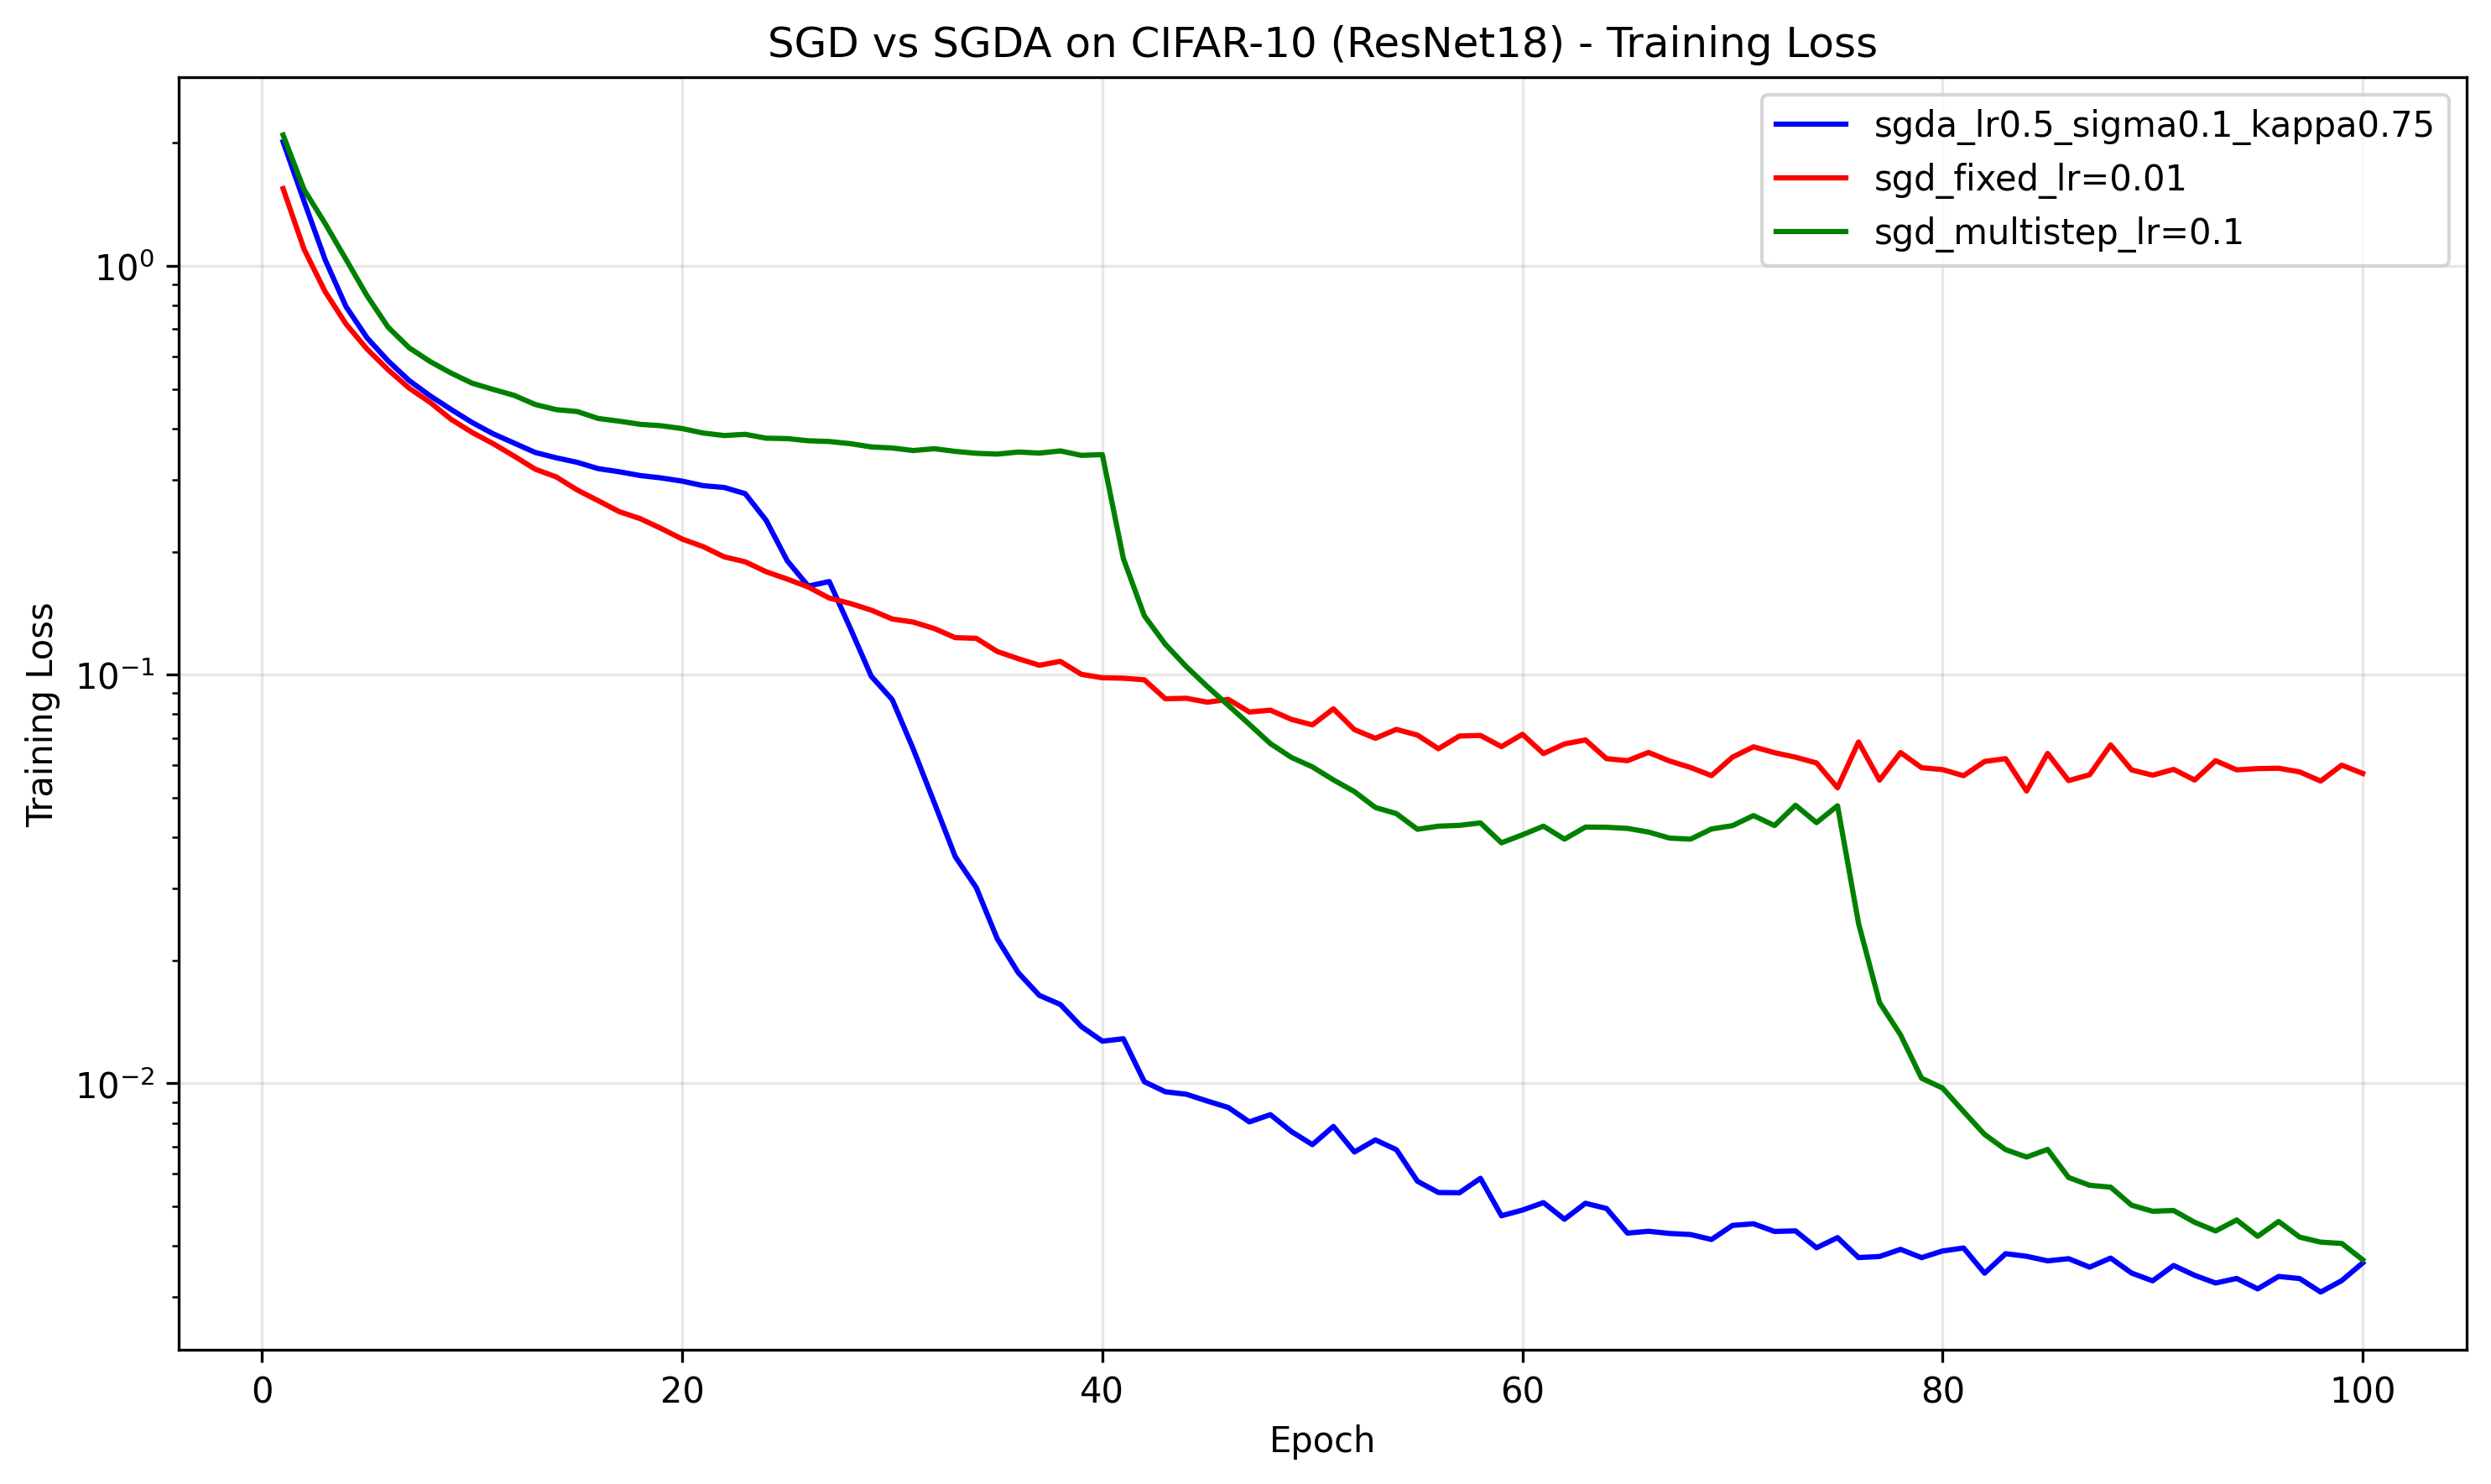

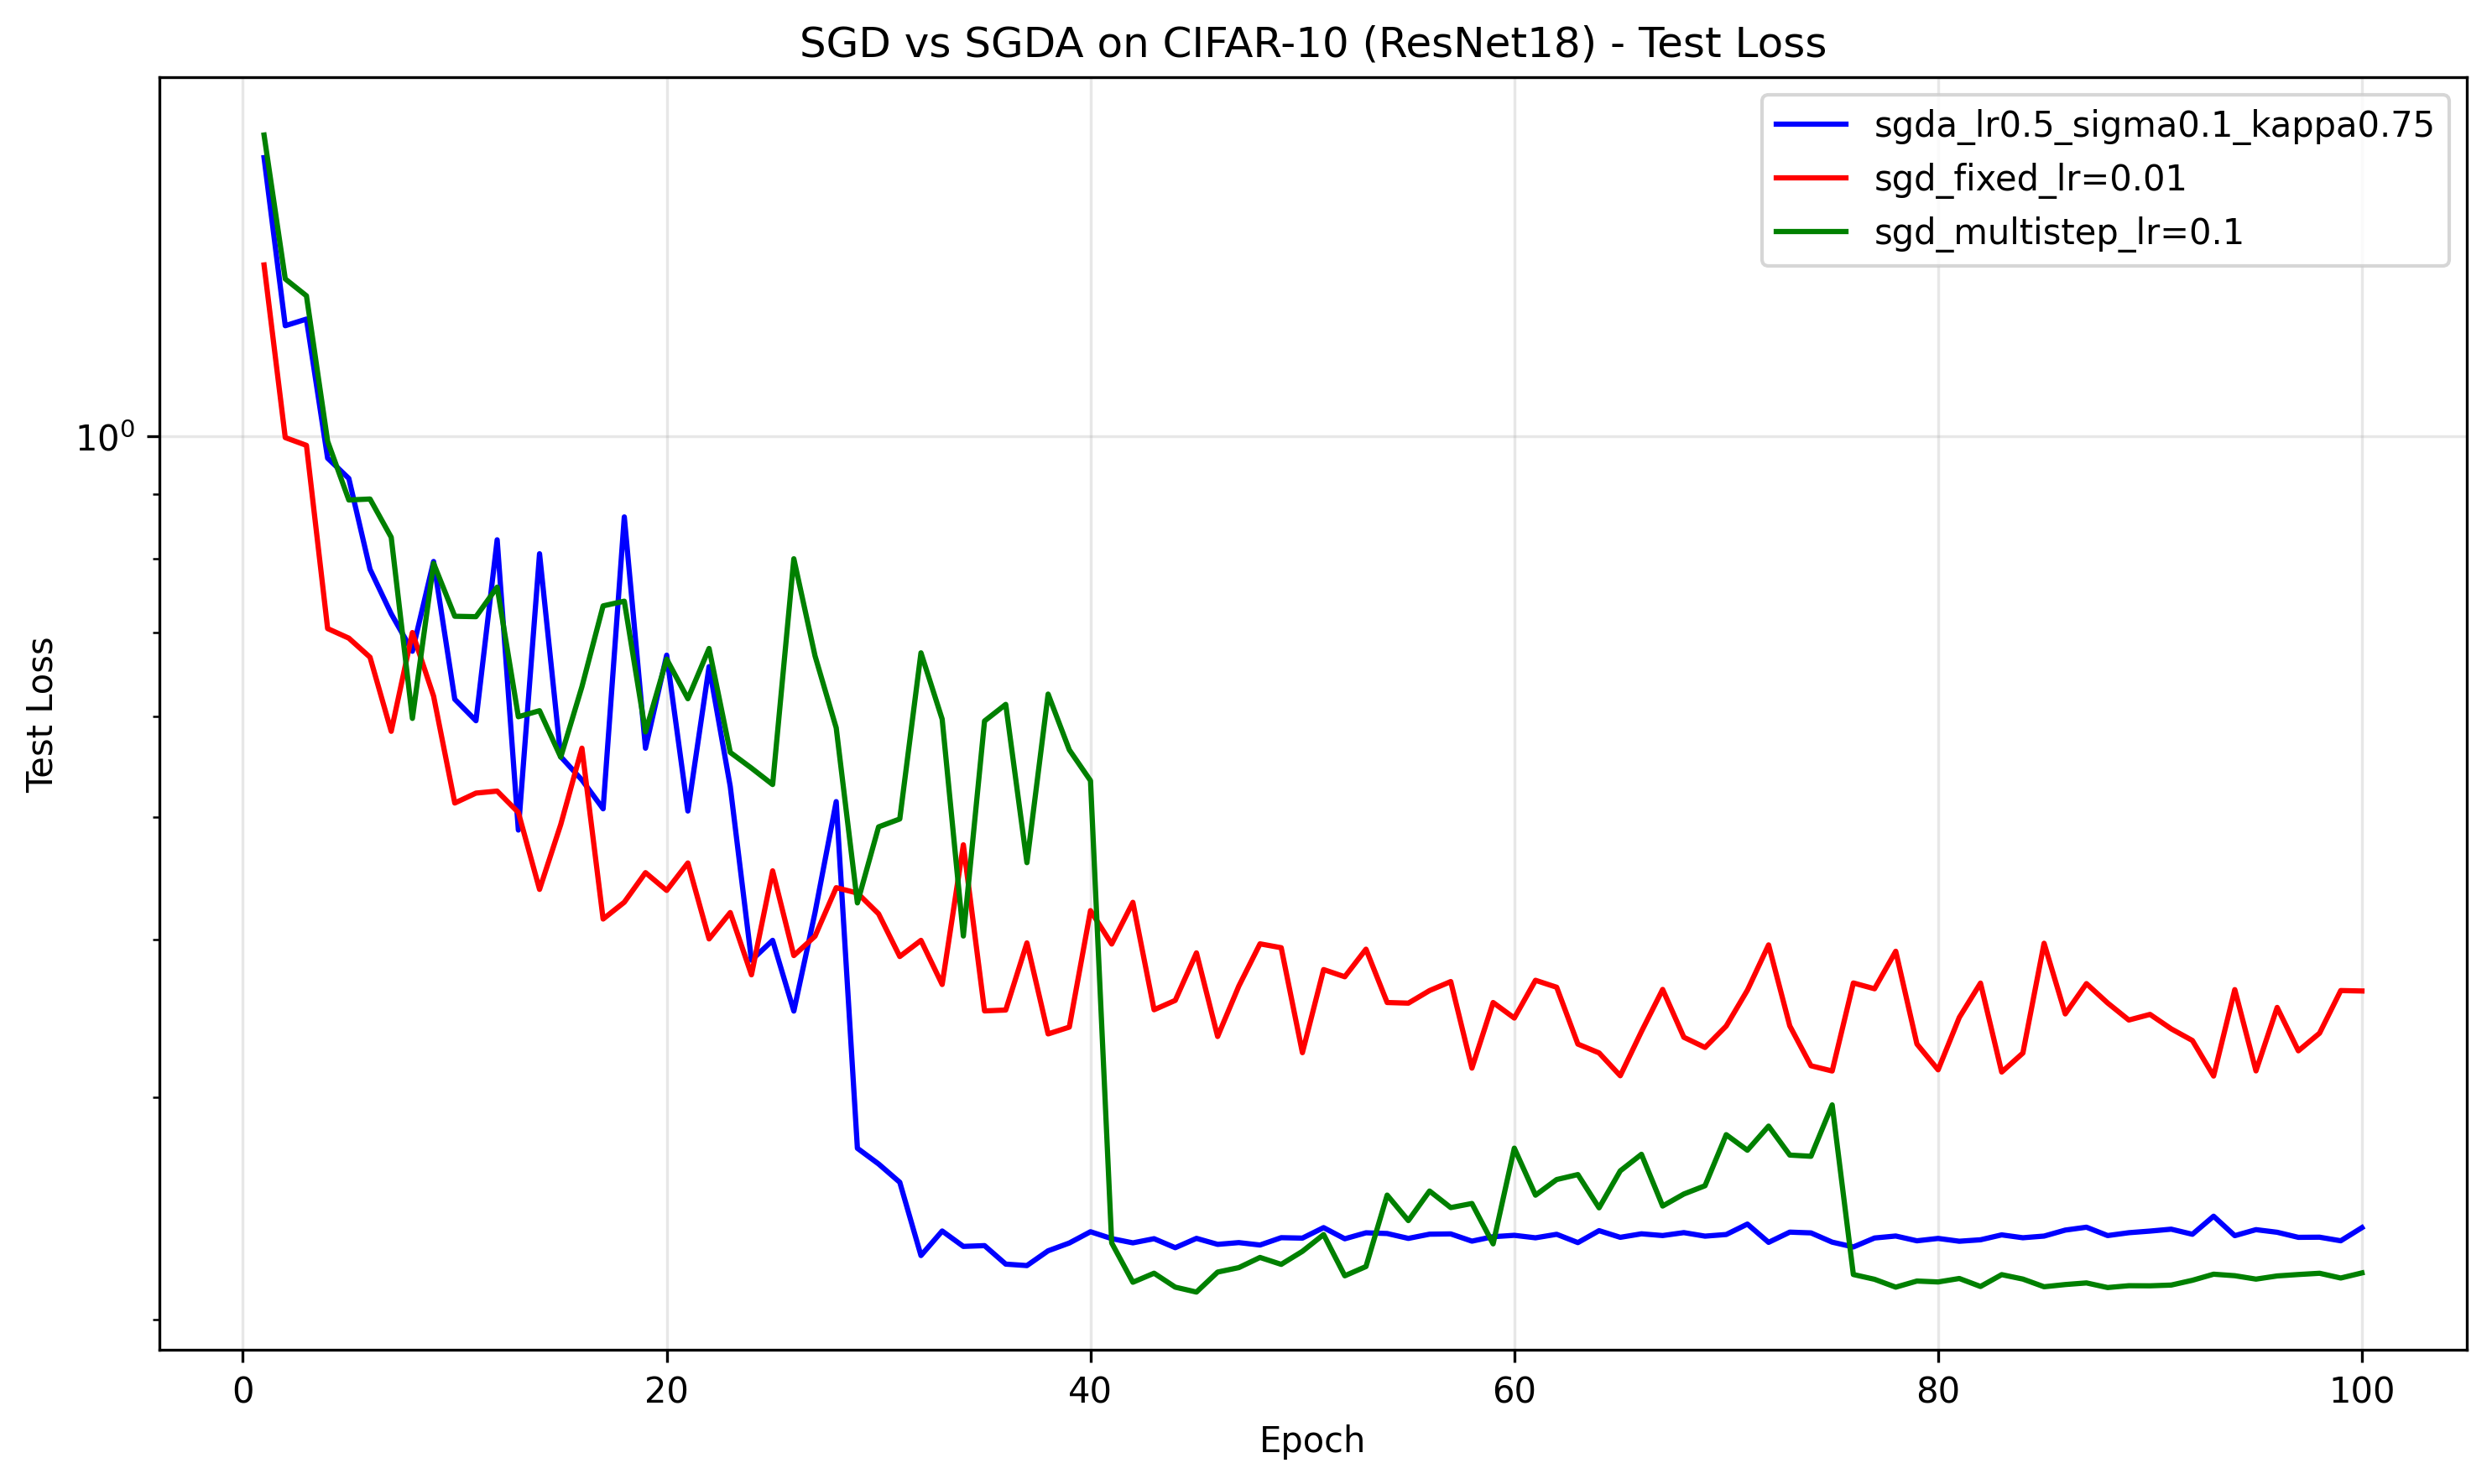

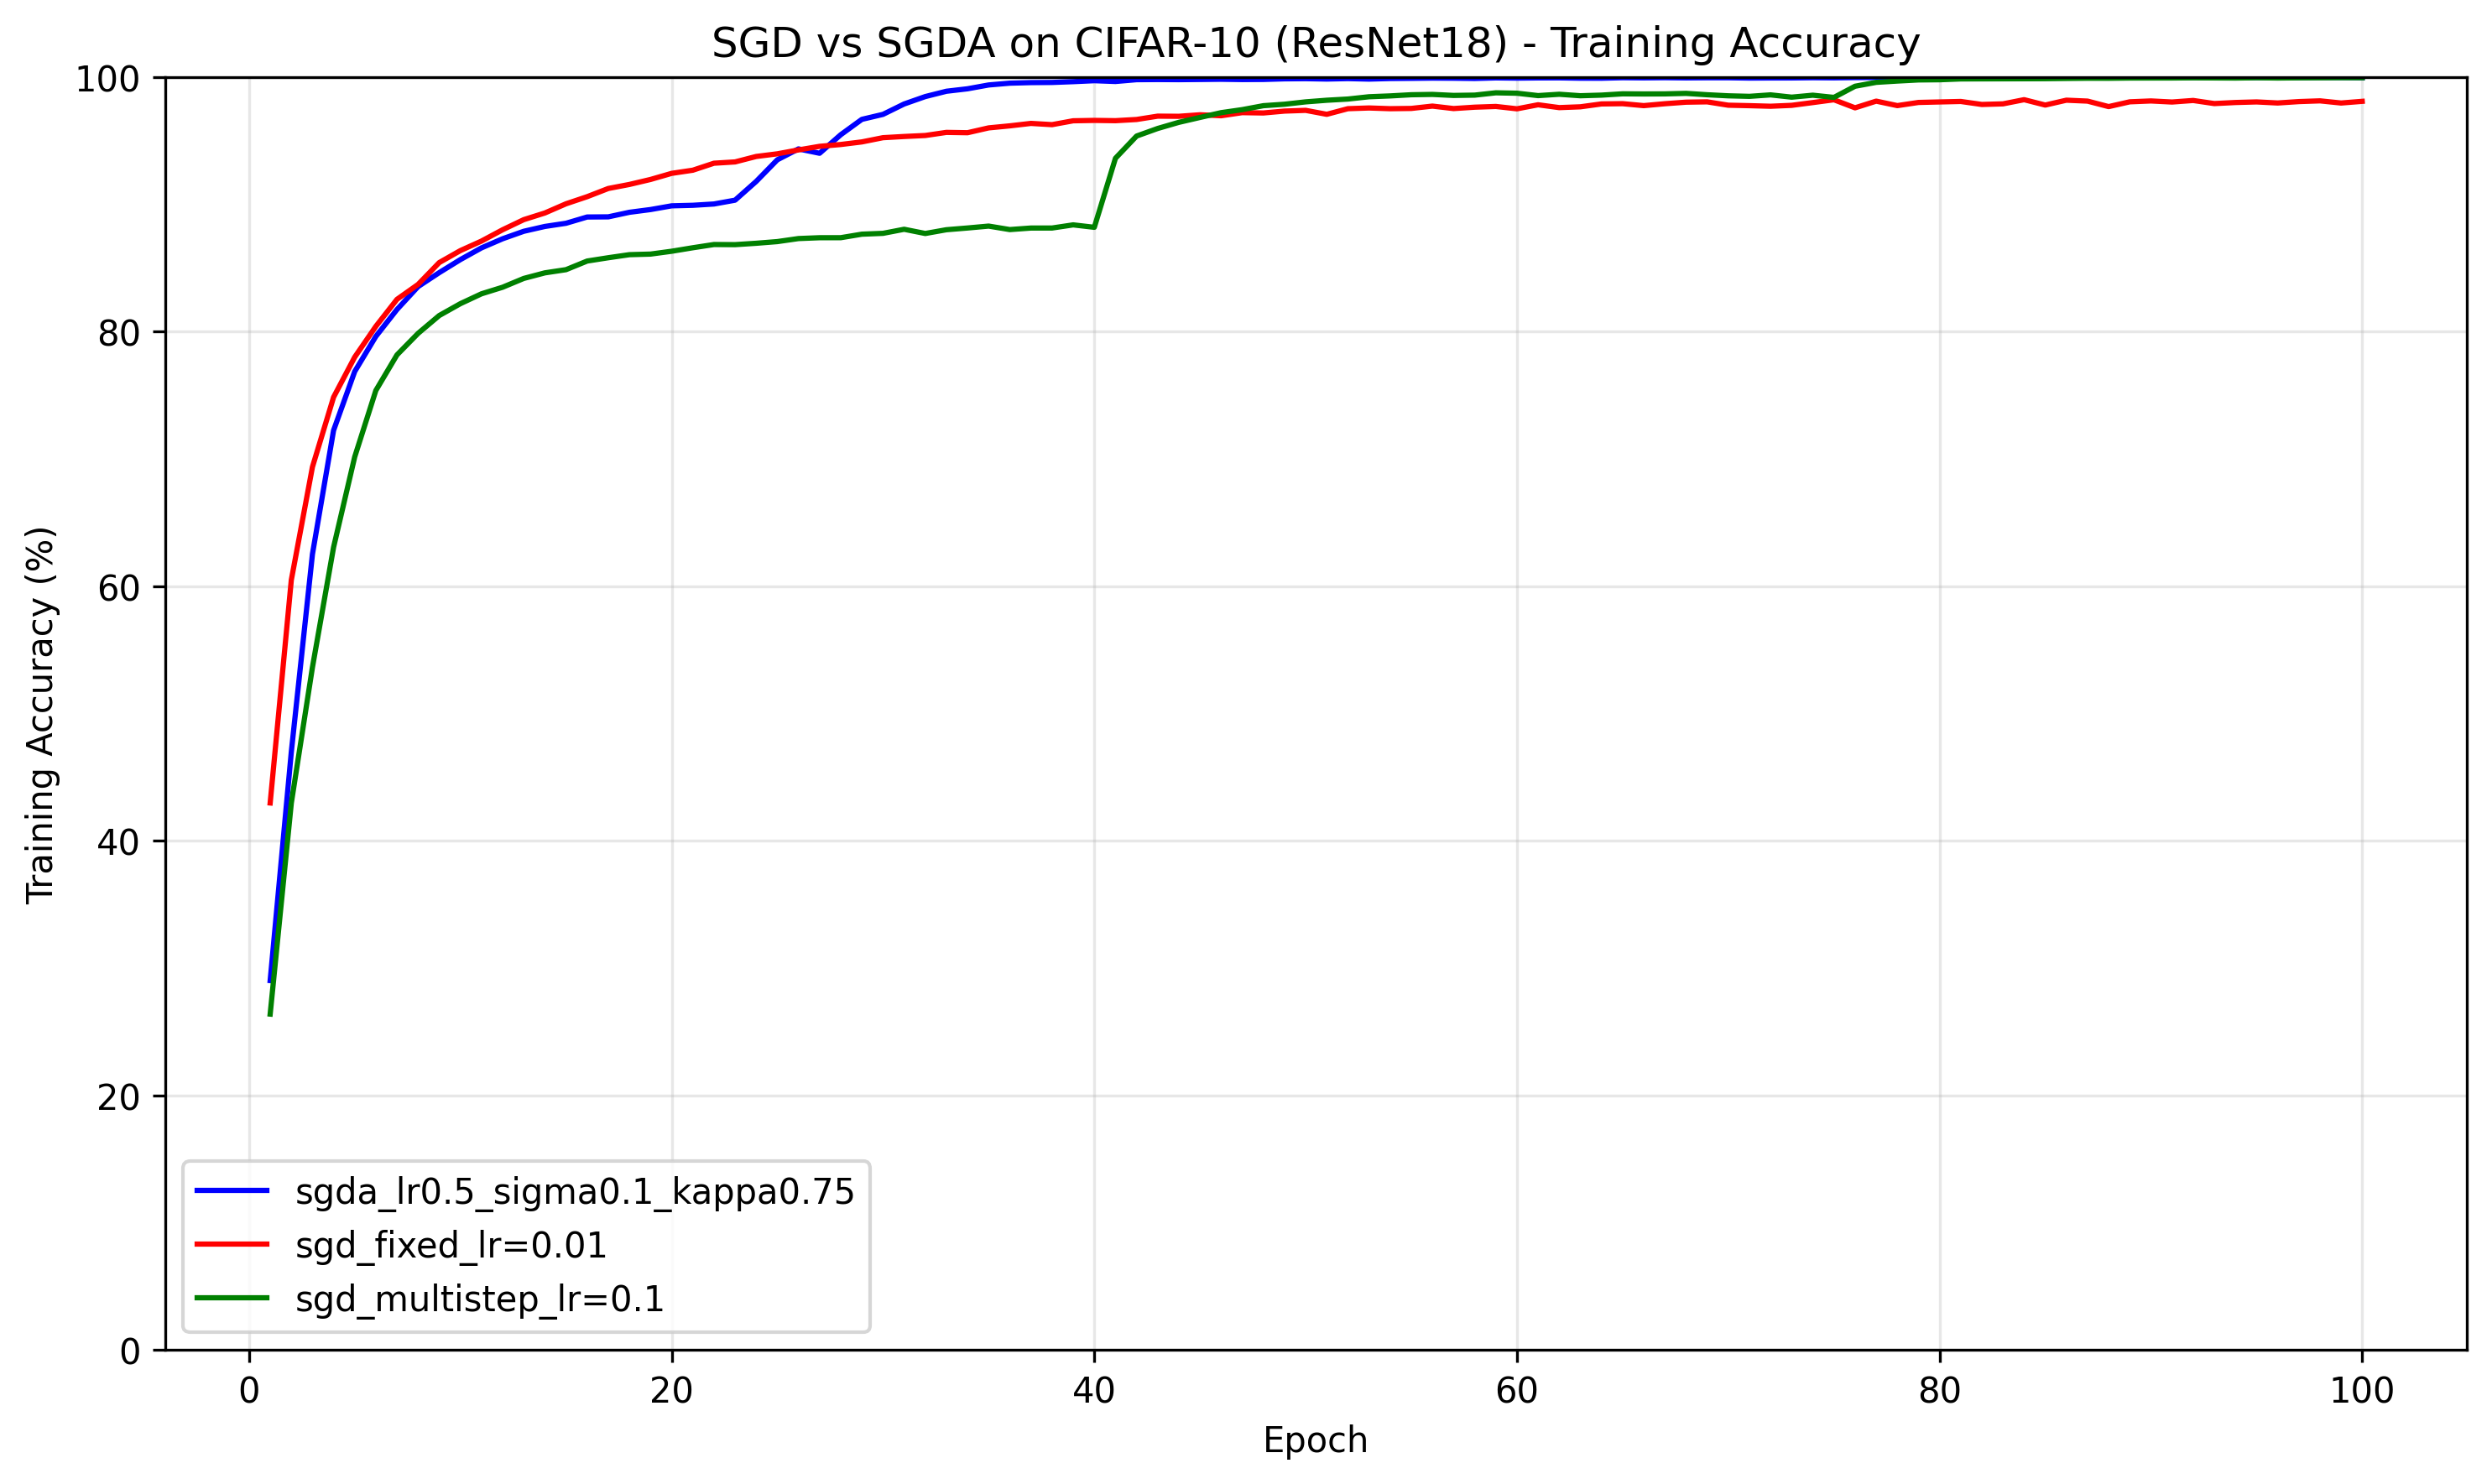

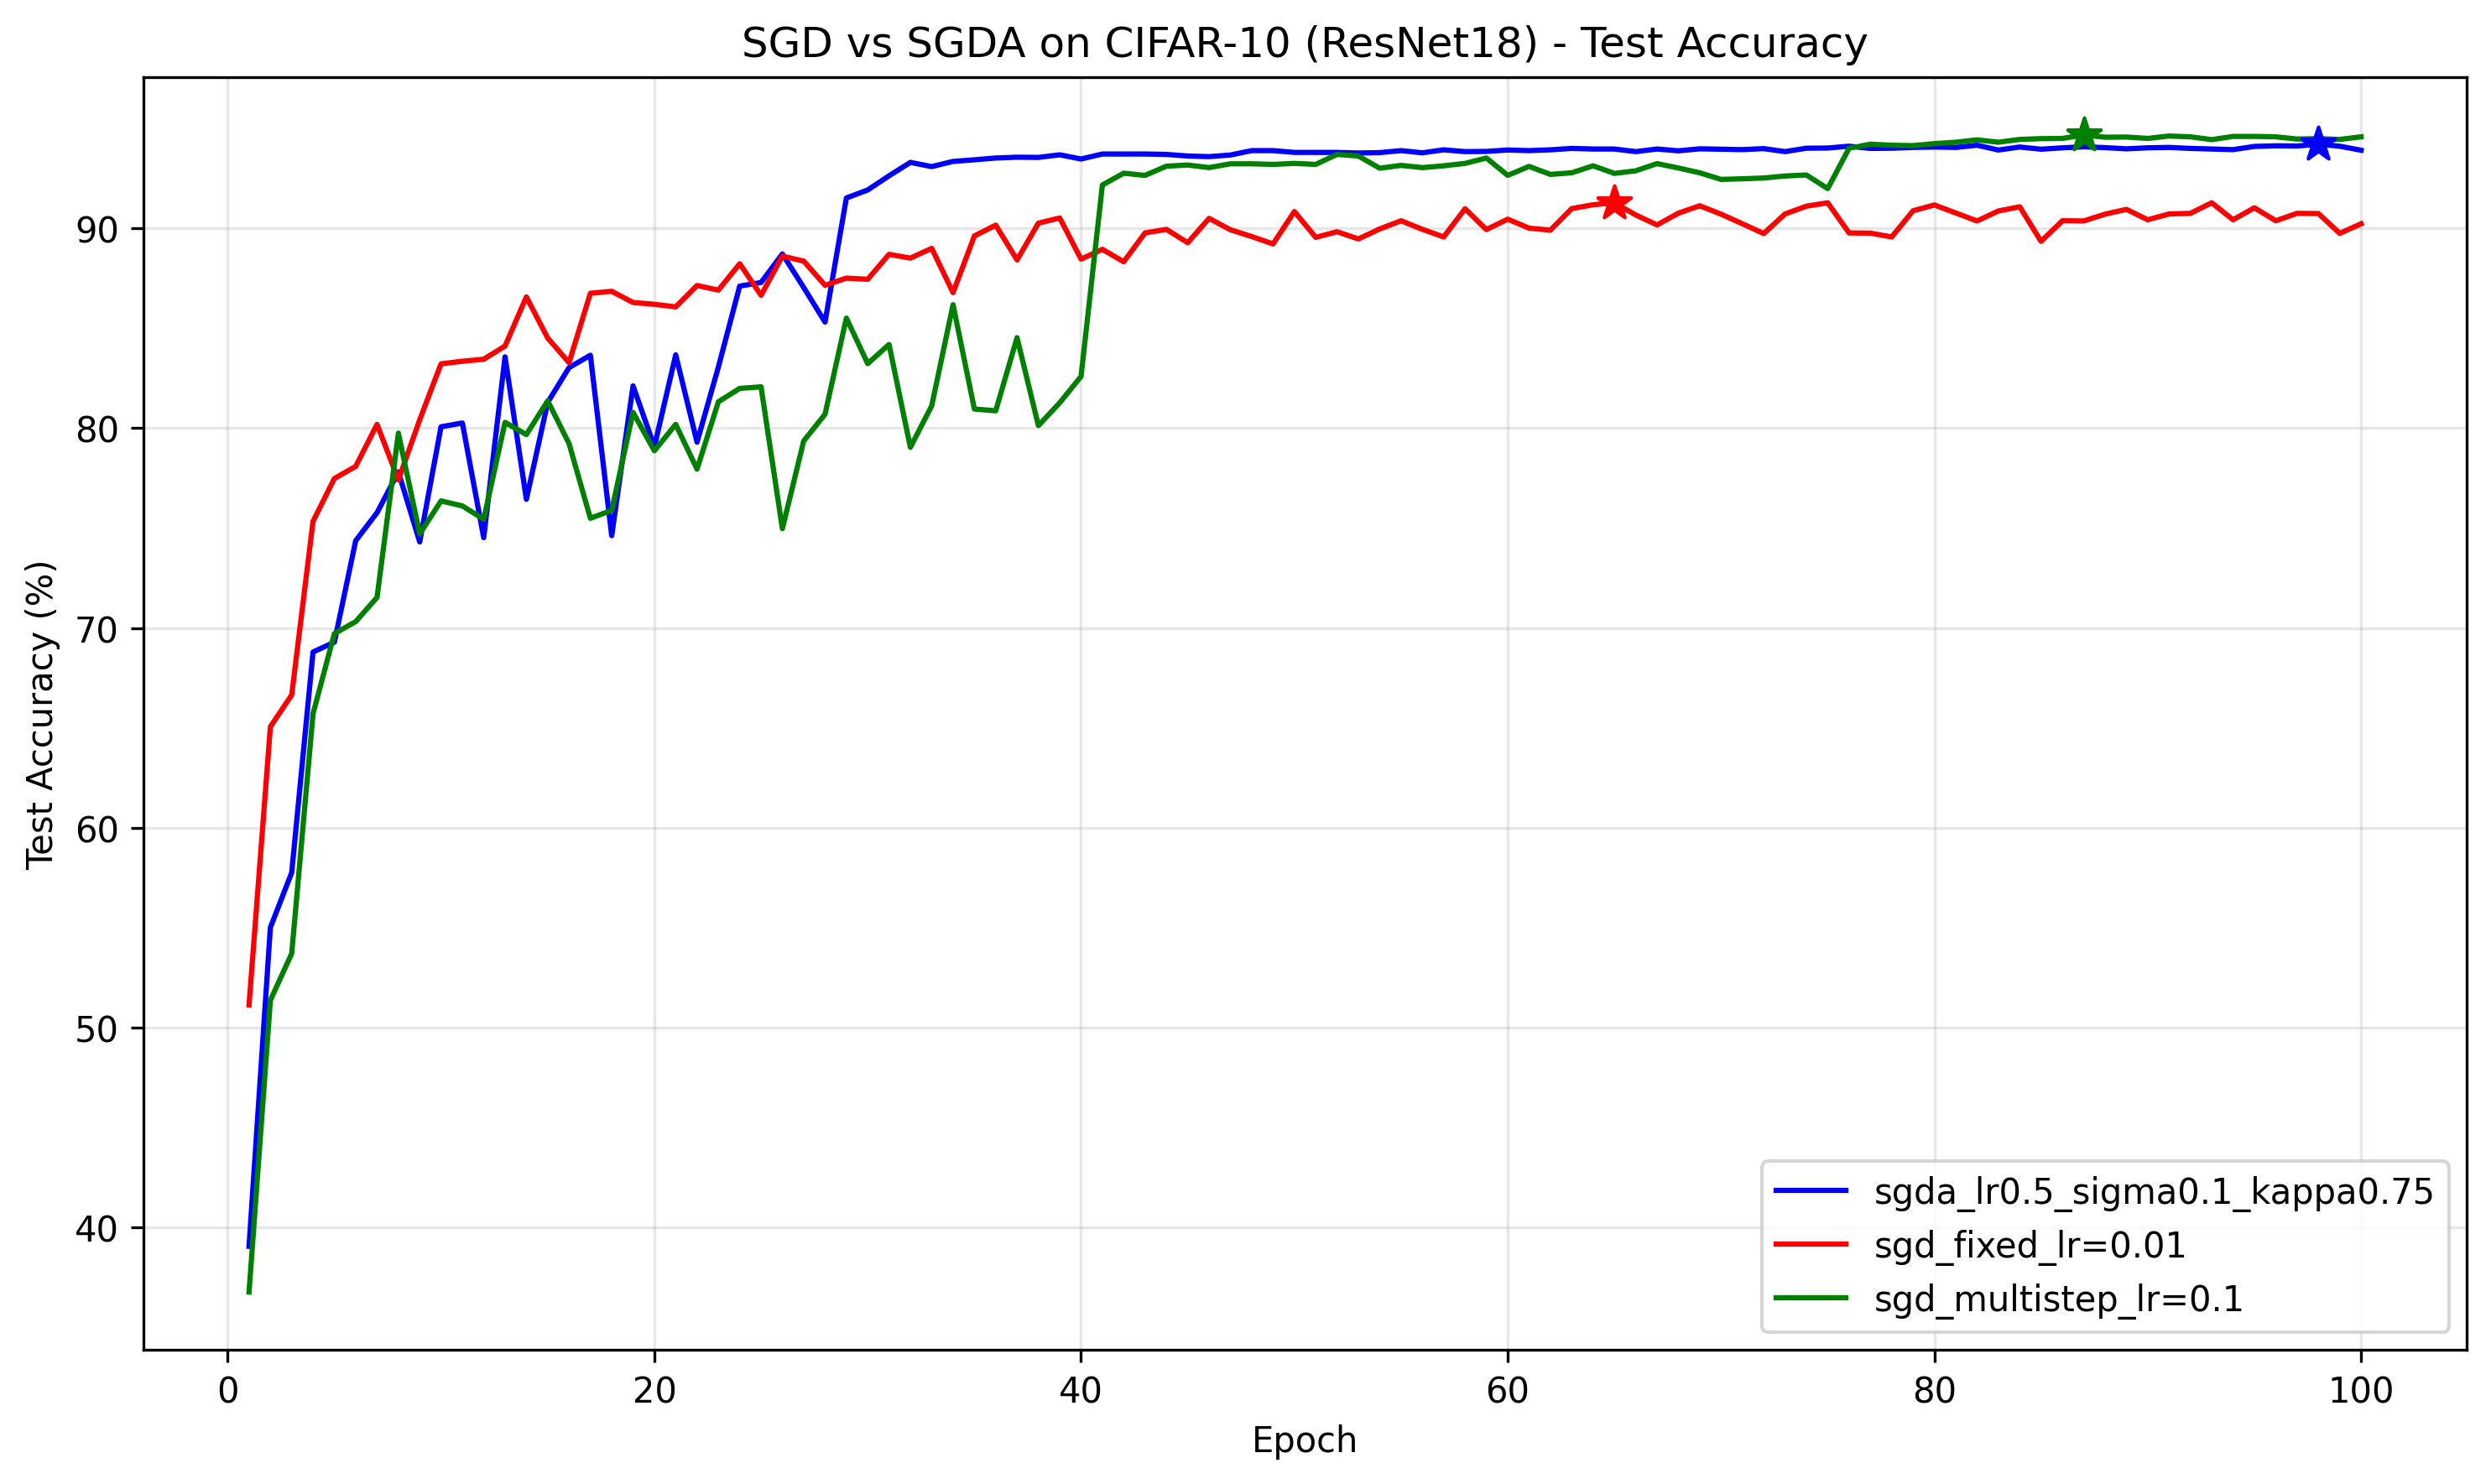

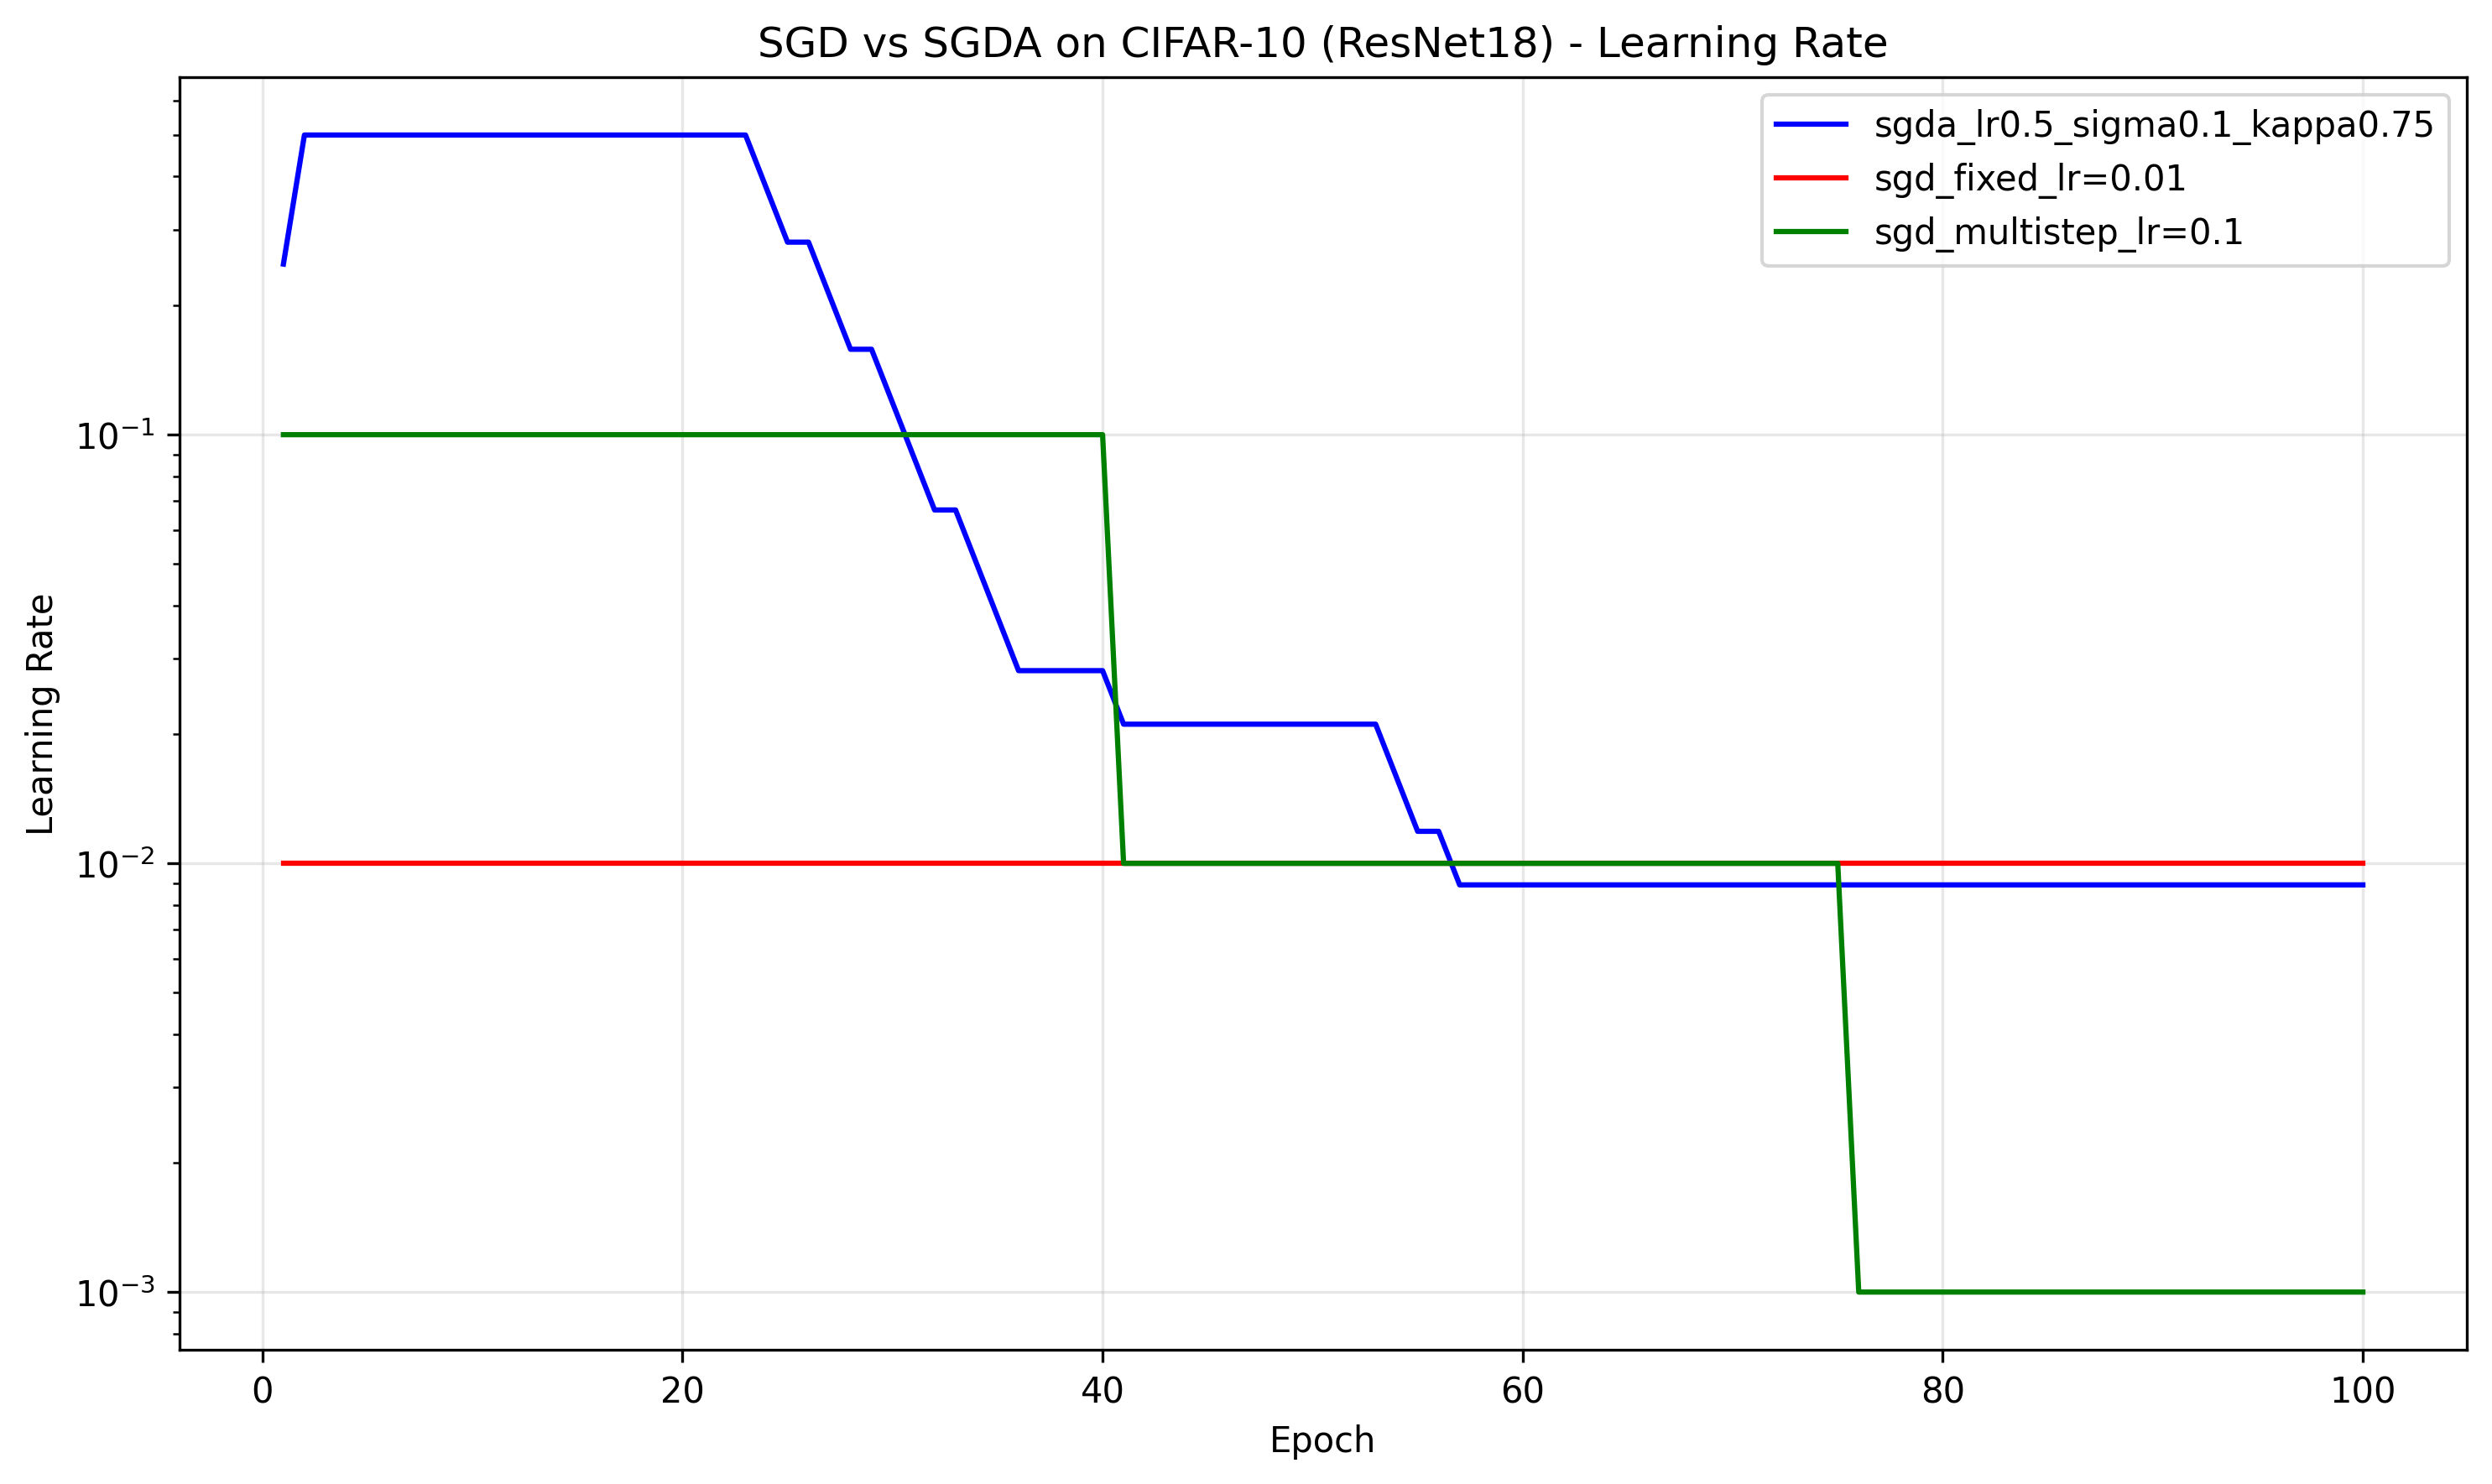

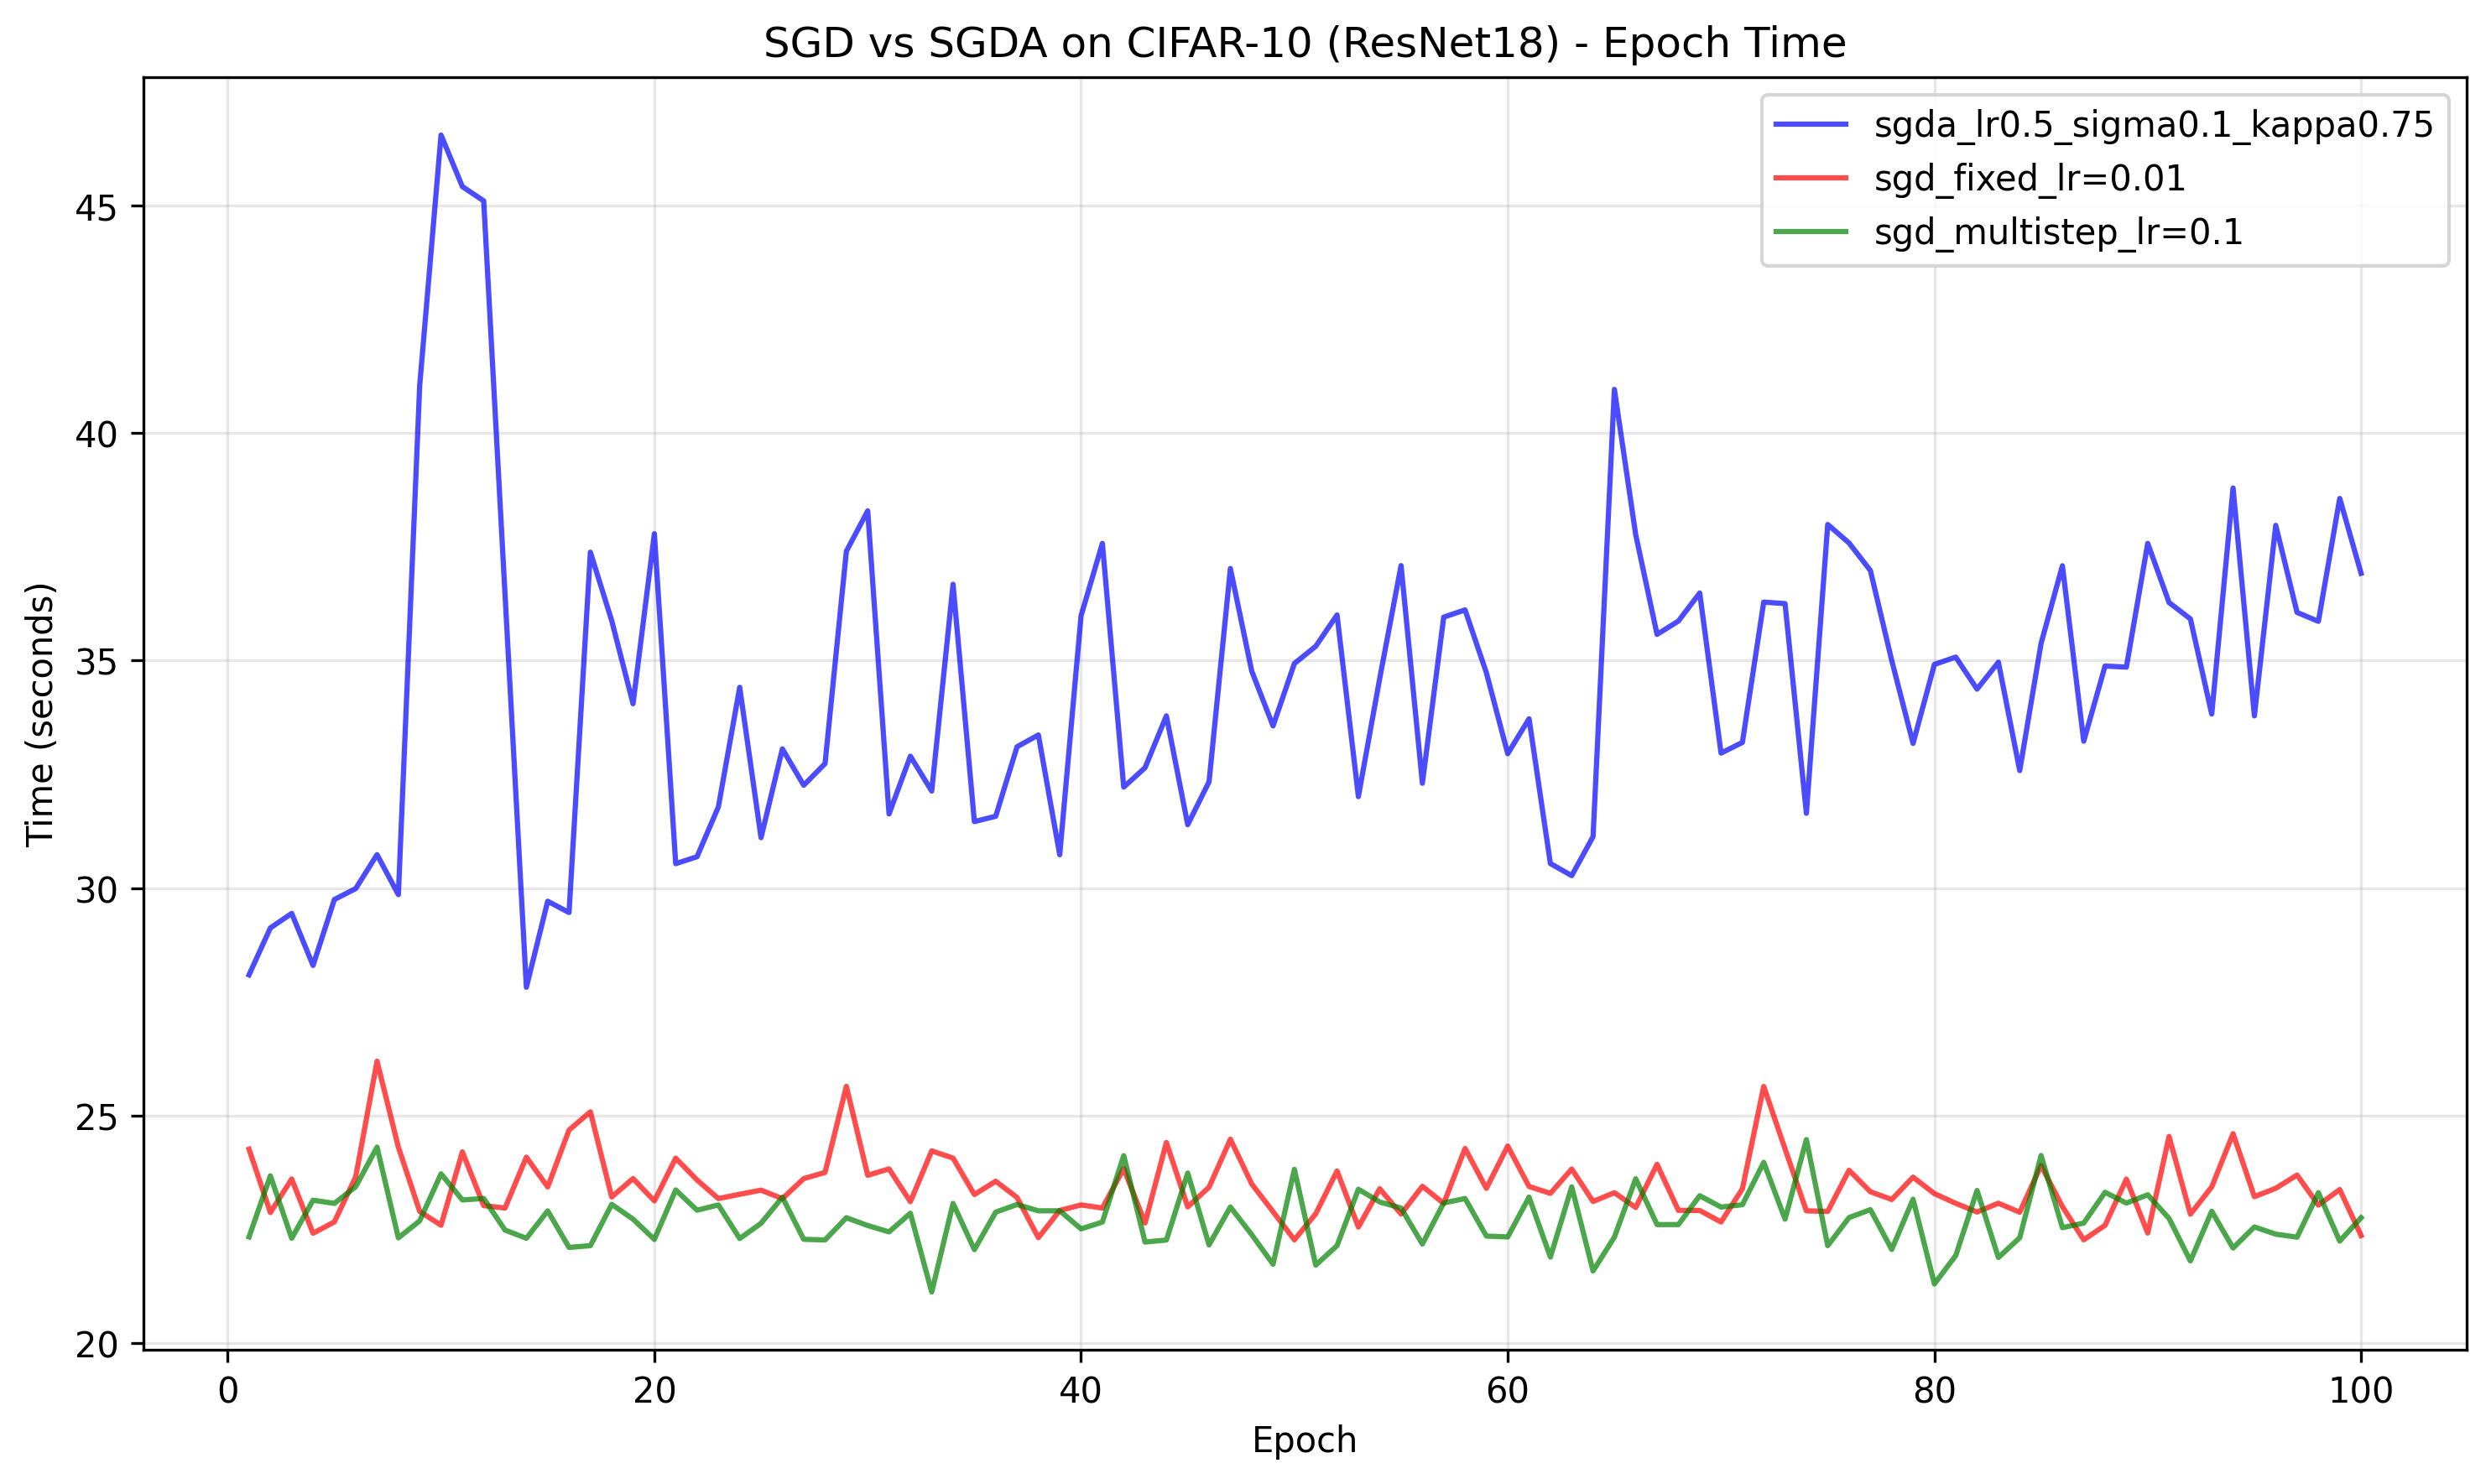

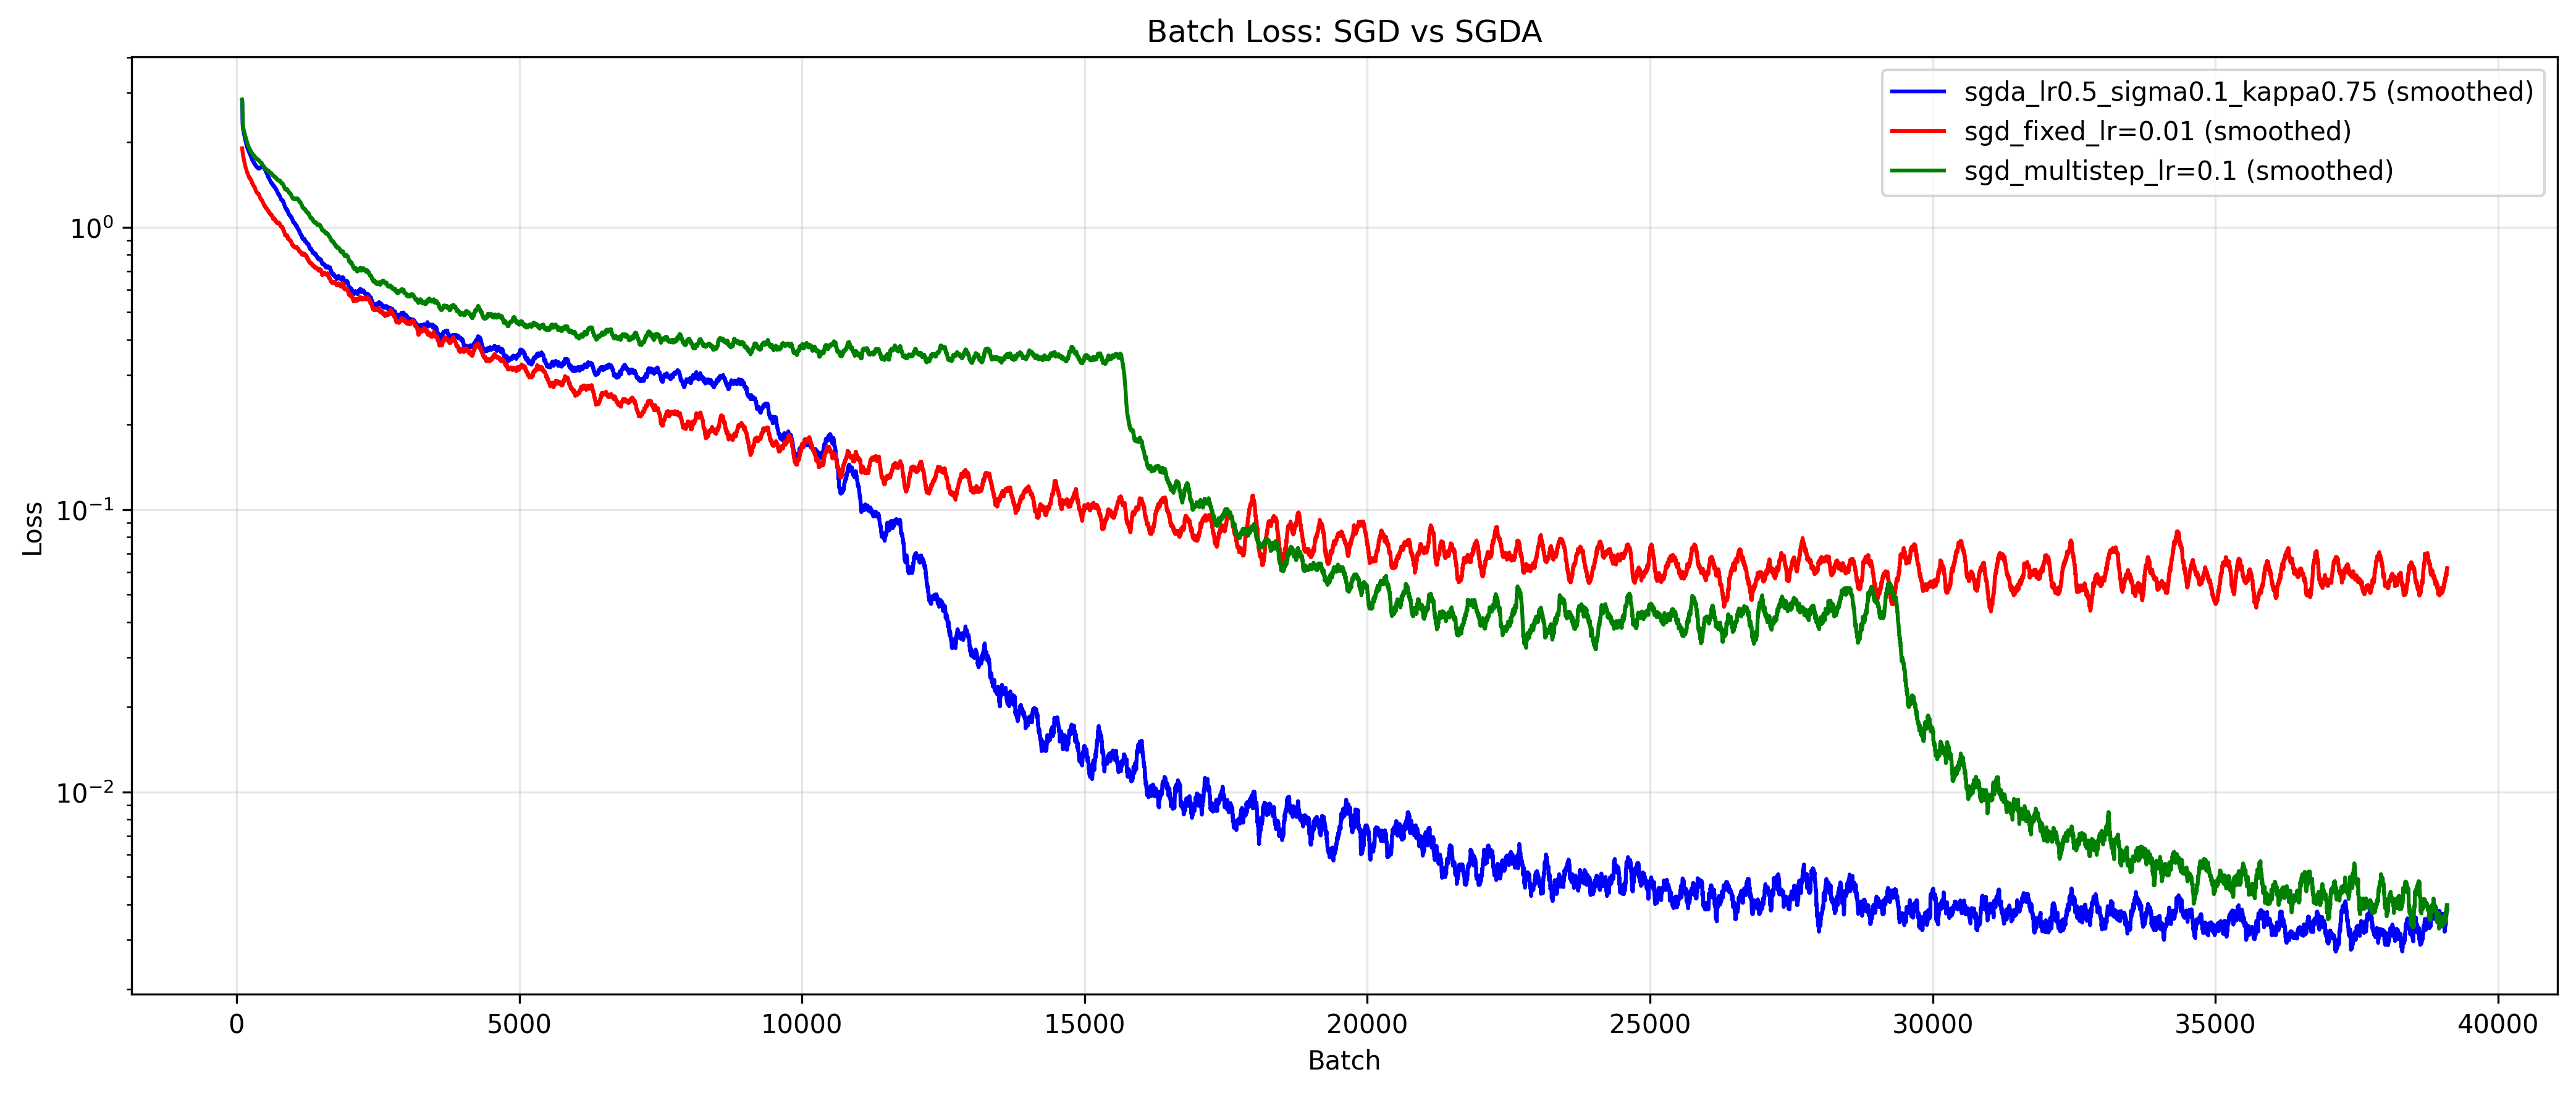

In [6]:
if metrics_dict:
    # Print comparison table
    print_comparison_table(metrics_dict)

    # Plot all comparison charts
    plot_comparison(metrics_dict, title="SGD vs SGDA on CIFAR-10 (ResNet18)")

    # Plot batch loss comparison
    plot_batch_loss_comparison(metrics_dict, window=100, title="Batch Loss: SGD vs SGDA")

Dựa vào plot ta có thể thấy, thuật toán SGDA tốt hơn SGD với lr cố định và hội tụ nhanh hơn hẳn 2 thuật toán còn lại. Tuy nhiên thời gian chạy mỗi epoch tốn gấp 2 vì phải tính trước loss (tuy nhiên có thể cài đặt tốt hơn và sử dụng loss trước đó thay vì phải tính lại)

Để ý rằng thuật toán SGDA ở đây có 2 epoch đầu để warmup, nếu như không có 2 epoch warmup này thì epoch đầu SGDA sẽ giảm LR xuống khoảng 0.015 và từ đó sẽ không giảm nữa, khiến thuật toán hoạt động như là SGD với fixed_lr = 0.01

Để lý giải cho việc này, tôi cho rằng với các epoch đầu tiên, khi trọng số của model đang là random. Thì với việc đi theo gradient, loss có thể tăng hoặc giảm bất kỳ và không ổn định, do đó, điều kiện Armijo fail liên tục khiến lr giảm nhanh. Để thực sự train model này hiệu quả, ta cần có 2 epoch để model ổn định (dùng SGD fixed LR) và các epoch sau đó có thể áp dụng SGDA để thuật toán tự lựa chọn LR hiệu quả.

Tuy kết quả cuối cùng thuật toán SGDA (94.21% test acc) chưa đánh bại được SGD (94.67% test acc) với multistep lr (giảm lr mỗi 30 epoch), nhưng việc hội tụ rất sớm và tự thích nghi chứng minh rằng thuật toán SGDA hoạt động tốt với việc huấn luyện các model học sâu